In [1]:
# Set the path and input parameters
import os
directory = os.getcwd() # the main directory of the project

# The credentials for the remote cluster
name = 'alina'
server = 'ecate'

In [2]:
# Importing the libraries and functions
from functions import *

# HMM analysis

Here we will construct and analyze HMM models retrieved from MSAs. We will utilize several databases as sources to enhance our analysis and gain valuable insights from the generated HMM profiles.

## 1. Load the data

We are working only with the disordered regions, thus we should keep only the related information.


In [3]:
# Obtain the information about one Uniprot query ID
curated_disprot_df = pd.read_csv('curated_disprot.csv')

## 2. hmmsearch results analysis

After performing `hmmsearch` against RP 75%, we retrieve the dataframes `hmmsearch_results_blast` and `hmmsearch_results_clustal` with the statistics.

In [4]:
# Retrieve the dataframe with the hmmsearch results - BLAST
hmmsearch_results_blast = pd.read_csv('{}/results/hmms/hmmsearch/hmmsearch_results_blast.csv'.format(directory))
hmmsearch_results_blast.head()

,E-value,score,bias,E-value.1,score.1,bias.1,exp,N,Sequence,hmm_from,hmm_to,hmm_length,ali_from,ali_to,ali_length,env_from,env_to,env_length
0,0.0,5406.7,5695.0,0.000036,36.0,9.0,378.4,365,A0A7M7NU54,1,35,35,246,282,37,246,283,38
1,0.0,2473.7,2447.2,0.000039,35.9,5.8,148.9,146,A0A7I8W901,1,34,34,273,306,34,273,308,36
2,0.0,2023.3,1971.1,0.000008,38.0,8.9,138.2,128,A0A8B7ZVU6,1,32,32,454,485,32,454,487,34
3,0.0,2013.1,1940.1,0.000008,38.0,8.9,136.2,127,A0A8B7ZRF1,1,32,32,382,413,32,382,415,34
4,0.0,1740.0,1752.7,0.000008,38.1,8.9,122.2,112,A0A8B7ZPY7,1,32,32,454,485,32,454,487,34


In [5]:
# Retrieve the dataframe with the hmmsearch results - ClustalOmega
hmmsearch_results_clustal = pd.read_csv('{}/results/hmms/hmmsearch/hmmsearch_results_clustal.csv'.format(directory))
hmmsearch_results_clustal.head()

,E-value,score,bias,E-value.1,score.1,bias.1,exp,N,Sequence,hmm_from,hmm_to,hmm_length,ali_from,ali_to,ali_length,env_from,env_to,env_length
0,7.100000e-32,121.2,13.5,8.100000e-32,121.0,13.5,1.0,1,A0A8C7BFT3,1,61,61,9,69,61,9,69,61
1,1.200000e-30,117.3,13.5,5.900000e-30,115.1,13.5,2.3,1,A0A2U3ZCX9,1,61,61,451,511,61,451,511,61
2,1.200000e-30,117.2,13.5,5.900000e-30,115.0,13.5,2.3,1,A0A2U3VQT6,1,61,61,454,514,61,454,514,61
3,1.300000e-30,117.2,13.5,5.900000e-30,115.1,13.5,2.2,1,A0A2Y9JGP3,1,61,61,450,510,61,450,510,61
4,1.300000e-30,117.1,13.5,5.900000e-30,115.1,13.5,2.2,1,A0A7N5P5S9,1,61,61,451,511,61,451,511,61


In [6]:
print('The length of the dataframe:', len(hmmsearch_results_blast))
print('The number of HMMs matching the alignment length:', len(hmmsearch_results_blast[hmmsearch_results_blast['hmm_length'] == hmmsearch_results_blast['ali_length']]))
print('The number of HMMs longer than the alignment length:', len(hmmsearch_results_blast[hmmsearch_results_blast['hmm_length'] > hmmsearch_results_blast['ali_length']]))
print('The number of HMMs shorter than the alignment length:', len(hmmsearch_results_blast[hmmsearch_results_blast['hmm_length'] < hmmsearch_results_blast['ali_length']]))

The length of the dataframe: 186445
The number of HMMs matching the alignment length: 96856
The number of HMMs longer than the alignment length: 22536
The number of HMMs shorter than the alignment length: 67053


In [7]:
shorter_blast = hmmsearch_results_blast[hmmsearch_results_blast['hmm_length'] < hmmsearch_results_blast['ali_length']]
shorter_blast.head()

,E-value,score,bias,E-value.1,score.1,bias.1,exp,N,Sequence,hmm_from,hmm_to,hmm_length,ali_from,ali_to,ali_length,env_from,env_to,env_length
0,0.0,5406.7,5695.0,3.600000e-05,36.0,9.0,378.4,365,A0A7M7NU54,1,35,35,246,282,37,246,283,38
10,0.0,1344.4,2445.1,1.100000e-03,31.2,8.7,150.0,125,A0A7M7P8Y1,1,35,35,218,253,36,218,254,37
14,0.0,1245.5,891.5,1.400000e-07,43.7,10.2,63.7,60,A0A7M7MYY4,1,34,34,206,240,35,206,242,37
17,0.0,1117.6,786.2,1.800000e-07,43.3,4.9,56.2,54,A0A7M7SY98,1,34,34,25,59,35,25,61,37
19,0.0,1066.3,759.9,1.800000e-07,43.4,4.9,54.2,52,A0A7M7NRP4,1,34,34,25,59,35,25,61,37


In [8]:
longer_blast = hmmsearch_results_blast[hmmsearch_results_blast['hmm_length'] > hmmsearch_results_blast['ali_length']]
longer_blast.head()

,E-value,score,bias,E-value.1,score.1,bias.1,exp,N,Sequence,hmm_from,hmm_to,hmm_length,ali_from,ali_to,ali_length,env_from,env_to,env_length
97,7.500000e-241,790.1,948.9,4.400000e-06,38.9,6.9,65.6,57,A0A7M7NUZ1,1,34,34,142,174,33,142,176,35
136,1.600000e-197,651.5,337.4,6.100000e-08,44.9,9.2,22.5,22,A0A6J8EPV6,1,34,34,533,565,33,533,567,35
229,2.500000e-148,494.0,337.3,5.700000e-05,35.4,10.6,20.3,19,A0A2R2MK42,1,34,34,73,105,33,73,107,35
285,8.900000e-143,476.3,460.2,2.300000e-02,27.0,9.4,31.2,31,A0A6P4ZRA4,1,33,33,173,204,32,173,206,34
431,5.200000e-135,451.4,522.6,7.100000e-07,41.4,6.5,35.0,29,D6X555,1,34,34,76,108,33,76,110,35


In [9]:
print('The length of the dataframe:', len(hmmsearch_results_clustal))
print('The number of HMMs matching the alignment length:', len(hmmsearch_results_clustal[hmmsearch_results_clustal['hmm_length'] == hmmsearch_results_clustal['ali_length']]))
print('The number of HMMs longer than the alignment length:', len(hmmsearch_results_clustal[hmmsearch_results_clustal['hmm_length'] > hmmsearch_results_clustal['ali_length']]))
print('The number of HMMs shorter than the alignment length:', len(hmmsearch_results_clustal[hmmsearch_results_clustal['hmm_length'] < hmmsearch_results_clustal['ali_length']]))

The length of the dataframe: 206952
The number of HMMs matching the alignment length: 96711
The number of HMMs longer than the alignment length: 26754
The number of HMMs shorter than the alignment length: 83487


In [10]:
shorter_clustal = hmmsearch_results_clustal[hmmsearch_results_clustal['hmm_length'] < hmmsearch_results_clustal['ali_length']]
shorter_clustal.head()

,E-value,score,bias,E-value.1,score.1,bias.1,exp,N,Sequence,hmm_from,hmm_to,hmm_length,ali_from,ali_to,ali_length,env_from,env_to,env_length
132,3.400000e-22,90.2,11.6,3.400000e-22,90.2,11.6,3.0,2,F6XLV7,1,61,61,480,541,62,480,541,62
133,7.000000e-22,89.2,15.9,7.000000e-22,89.2,15.9,2.4,1,A0A1A6HSD7,2,61,60,244,305,62,243,305,63
139,2.600000e-20,84.2,15.4,9.000000e-20,82.4,15.4,2.0,1,G3HIE4,2,61,60,448,509,62,447,509,63
142,6.700000e-20,82.8,16.5,1.800000e-19,81.5,16.5,1.8,1,A0A6J0DUB0,1,61,61,461,524,64,461,524,64
143,7.300000e-20,82.7,16.5,1.800000e-19,81.4,16.5,1.8,1,A0A6J0DV05,1,61,61,467,530,64,467,530,64


In [11]:
longer_clustal = hmmsearch_results_clustal[hmmsearch_results_clustal['hmm_length'] > hmmsearch_results_clustal['ali_length']]
longer_clustal.head()

,E-value,score,bias,E-value.1,score.1,bias.1,exp,N,Sequence,hmm_from,hmm_to,hmm_length,ali_from,ali_to,ali_length,env_from,env_to,env_length
63,2.900000e-28,109.6,12.8,2.900000e-28,109.6,12.8,2.2,1,A0A8J6A1V4,1,61,61,444,503,60,444,503,60
79,2.100000e-27,106.9,14.6,2.100000e-27,106.9,14.6,2.5,1,A0A8C9H9L8,1,61,61,445,504,60,445,504,60
87,1.300000e-26,104.4,14.2,4.600000e-26,102.6,14.2,2.1,1,A0A8C8YAS1,1,61,61,451,510,60,451,510,60
107,1.600000e-25,100.8,15.1,7.600000e-25,98.7,15.1,2.3,1,A0A6G1AVP8,1,61,61,437,496,60,437,496,60
114,6.700000e-25,98.9,12.6,2.200000e-24,97.2,12.6,2.0,1,A0A8B7VRK7,2,61,60,423,480,58,422,480,59


## 3. HMM and Pfam comparison

We took the results of `hmmsearch` and performed a search against Interpro database. Thus we obtained the Pfam domains corresponding to the results from `hmmsearch`.

In the following dataframes I directly compared two models: Pfam-HMM and DisProt-HMM. 

3 types of overlap were calculated:
- the common part divided by Pfam-HMM length (`overl_pfam`)
- the common part divided by DisProt-HMM length (`overl_hmm`)
- and the overall overlap: the common part divided by the **maximum length** combined by Pfam-HMM and DisProt-HMM lengths together (`overl_perc`).

In [12]:
# Load a dataframe of Pfam regions - BLAST
pfam_blast = pd.read_csv('{}/results/pfam/pfam_overlap/pfam_blast.csv'.format(directory))
print('The number of regions for the hmmsearch results on BLAST output in Interpro:', len(pfam_blast))
print('The number of retrieved Pfam domains:', len(set(pfam_blast['pfam_id'])))
pfam_blast.head()

The number of regions for the hmmsearch results on BLAST output in Interpro: 949687
The number of retrieved Pfam domains: 774


,uniprot_id,pfam_id,ipr_id,start_pfam,end_pfam,length_pfam,hmm_from,hmm_to,hmm_length,ali_from,...,ali_length,env_from,env_to,env_length,overl_len,overl_pfam,overl_ali,non_overl_len,overl_perc,overlap_sym
0,A0A010Q304,PF02775,IPR011766,499,646,148,1,39,39,650,...,39,650,689,40,0,0.00,0.0,194,0.00,0.00
1,A0A010Q304,PF02775,IPR011766,499,646,148,1,15,15,583,...,15,583,597,15,15,10.14,100.0,134,10.14,0.18
2,A0A010Q304,PF00205,IPR012000,289,434,146,1,39,39,650,...,39,650,689,40,0,0.00,0.0,616,0.00,0.00
3,A0A010Q304,PF00205,IPR012000,289,434,146,1,15,15,583,...,15,583,597,15,0,0.00,0.0,458,0.00,0.00
4,A0A010Q304,PF02776,IPR012001,91,205,115,1,39,39,650,...,39,650,689,40,0,0.00,0.0,1043,0.00,0.00


In [13]:
# Load a dataframe of Pfam regions - ClustalOmega
pfam_clustal = pd.read_csv('{}/results/pfam/pfam_overlap/pfam_clustal.csv'.format(directory))
print('The number of regions for the hmmsearch results on ClustalOmega output in Interpro:', len(pfam_clustal))
print('The number of retrieved Pfam domains:', len(set(pfam_clustal['pfam_id'])))
pfam_clustal.head()

The number of regions for the hmmsearch results on ClustalOmega output in Interpro: 1109890
The number of retrieved Pfam domains: 869


,uniprot_id,pfam_id,ipr_id,start_pfam,end_pfam,length_pfam,hmm_from,hmm_to,hmm_length,ali_from,...,ali_length,env_from,env_to,env_length,overl_len,overl_pfam,overl_ali,non_overl_len,overl_perc,overlap_sym
0,A0A010Q304,PF02775,IPR011766,499,646,148,1,15,15,583,...,15,583,597,15,15,10.14,100.0,134,10.14,0.18
1,A0A010Q304,PF02775,IPR011766,499,646,148,1,39,39,650,...,39,650,689,40,0,0.00,0.0,194,0.00,0.00
2,A0A010Q304,PF00205,IPR012000,289,434,146,1,15,15,583,...,15,583,597,15,0,0.00,0.0,458,0.00,0.00
3,A0A010Q304,PF00205,IPR012000,289,434,146,1,39,39,650,...,39,650,689,40,0,0.00,0.0,616,0.00,0.00
4,A0A010Q304,PF02776,IPR012001,91,205,115,1,15,15,583,...,15,583,597,15,0,0.00,0.0,885,0.00,0.00


### Models comparison (Pfam-HMM and DisProt-HMM)

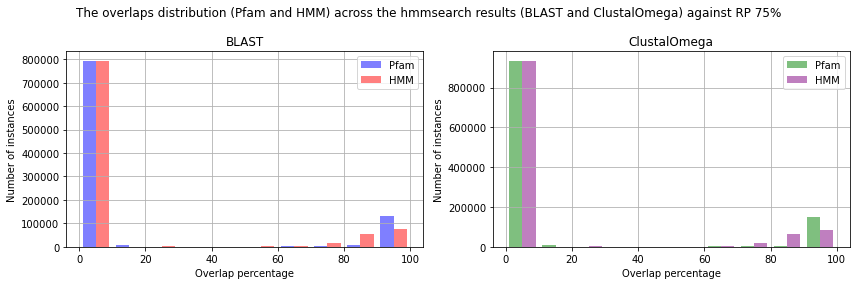

In [14]:
# Plot the histogram of overlaps % for Pfam and HMM
plt.rcParams['figure.figsize'] = [12, 4]
fig, ax = plt.subplots(1, 2, sharex=True)

ax[0].hist([pfam_blast['overl_pfam'], pfam_blast['overl_ali']],
             bins=10, alpha=0.5, color=['blue', 'red'],
             label=['Pfam', 'HMM'])

ax[1].hist([pfam_clustal['overl_pfam'], pfam_clustal['overl_ali']],
             bins=10, alpha=0.5, color=['green', 'purple'],
             label=['Pfam', 'HMM'])

ax[0].set_xlabel('Overlap percentage')
ax[1].set_xlabel('Overlap percentage')
ax[0].set_ylabel('Number of instances')
ax[1].set_ylabel('Number of instances')

ax[0].set_title('BLAST')
ax[1].set_title('ClustalOmega')

ax[0].legend()
ax[1].legend()

ax[0].grid(True)
ax[1].grid(True)

plt.suptitle('The overlaps distribution (Pfam and HMM) across the hmmsearch results (BLAST and ClustalOmega) against RP 75%')
plt.tight_layout()
plt.show()

In [15]:
# Calculate how many models do not overlap
zero_count_blast = (pfam_blast['overl_perc'] == 0).sum()
total_count_blast = len(pfam_blast)
percentage_blast = '{:.2f}'.format((zero_count_blast / total_count_blast) * 100)

zero_count_clustal = (pfam_clustal['overl_perc'] == 0).sum()
total_count_clustal = len(pfam_clustal)
percentage_clustal = '{:.2f}'.format((zero_count_clustal / total_count_clustal) * 100)

print('Non-overlapping models count (BLAST): {}'.format(zero_count_blast), '\n'
     'The share of non-overlapping models (BLAST): {}%'.format(percentage_blast))
print('Non-overlapping models count (ClustalOmega): {}'.format(zero_count_clustal), '\n'
     'The share of non-overlapping models (ClustalOmega): {}%'.format(percentage_clustal))

Non-overlapping models count (BLAST): 789066 
The share of non-overlapping models (BLAST): 83.09%
Non-overlapping models count (ClustalOmega): 930629 
The share of non-overlapping models (ClustalOmega): 83.85%


In [16]:
# Non-zero (nz) overlaps - BLAST
nz_blast = pfam_blast[pfam_blast['overl_perc'] != 0]
print('The number of overlapping models (BLAST):', len(nz_blast))
nz_blast.head()

The number of overlapping models (BLAST): 160621


,uniprot_id,pfam_id,ipr_id,start_pfam,end_pfam,length_pfam,hmm_from,hmm_to,hmm_length,ali_from,...,ali_length,env_from,env_to,env_length,overl_len,overl_pfam,overl_ali,non_overl_len,overl_perc,overlap_sym
1,A0A010Q304,PF02775,IPR011766,499,646,148,1,15,15,583,...,15,583,597,15,15,10.14,100.00,134,10.14,0.18
6,A0A010Q7P7,PF00018,IPR001452,435,481,47,10,65,56,428,...,58,424,487,64,47,100.00,81.03,12,81.03,0.90
10,A0A010QT56,PF00018,IPR001452,707,751,45,17,67,51,707,...,51,700,758,59,45,100.00,88.24,7,88.24,0.94
14,A0A010R8W1,PF00018,IPR001452,956,1004,49,17,65,49,957,...,52,954,1010,57,48,97.96,92.31,6,90.57,0.95
15,A0A010RFU4,PF00018,IPR001452,229,273,45,12,67,56,225,...,56,218,283,66,45,100.00,80.36,12,80.36,0.89


In [17]:
# Non-zero (nz) overlaps - ClustalOmega
nz_clustal = pfam_clustal[pfam_clustal['overl_perc'] != 0]
print('The number of overlapping models (ClustalOmega):', len(nz_clustal))
nz_clustal.head()

The number of overlapping models (ClustalOmega): 179261


,uniprot_id,pfam_id,ipr_id,start_pfam,end_pfam,length_pfam,hmm_from,hmm_to,hmm_length,ali_from,...,ali_length,env_from,env_to,env_length,overl_len,overl_pfam,overl_ali,non_overl_len,overl_perc,overlap_sym
0,A0A010Q304,PF02775,IPR011766,499,646,148,1,15,15,583,...,15,583,597,15,15,10.14,100.00,134,10.14,0.18
6,A0A010Q7P7,PF00018,IPR001452,435,481,47,10,65,56,428,...,58,424,487,64,47,100.00,81.03,12,81.03,0.90
8,A0A010QBJ0,PF00018,IPR001452,1080,1125,46,18,68,51,1082,...,51,1073,1134,62,44,95.65,86.27,10,83.02,0.91
11,A0A010QT56,PF00018,IPR001452,707,751,45,16,66,51,706,...,51,694,758,65,45,100.00,88.24,7,88.24,0.94
15,A0A010R8W1,PF00018,IPR001452,956,1004,49,19,66,48,959,...,51,950,1010,61,46,93.88,90.20,9,85.19,0.92


### Models comparison with DisProt
In this part I've taken into account the overlap between two models (Pfam-HMM and DisProt-HMM) with the regions given in the curated DisProt database.

In [21]:
print('The mean of HMM overlap with Pfam-HMM (BLAST): {:.2f}%'.format(pfam_blast['overl_pfam'].mean()))
print('The mean of HMM overlap with Pfam-HMM (ClustalOmega): {:.2f}%'.format(pfam_clustal['overl_pfam'].mean()))

The mean of HMM overlap with Pfam-HMM (BLAST): 15.05%
The mean of HMM overlap with Pfam-HMM (ClustalOmega): 14.49%


In [22]:
print('The mean of HMM overlap with Disprot-HMM (BLAST): {:.2f}%'.format(pfam_blast['overl_ali'].mean()))
print('The mean of HMM overlap with Disprot-HMM (ClustalOmega): {:.2f}%'.format(pfam_clustal['overl_ali'].mean()))

The mean of HMM overlap with Disprot-HMM (BLAST): 14.31%
The mean of HMM overlap with Disprot-HMM (ClustalOmega): 13.73%


In [23]:
print('The difference between mean of HMM and Pfam overlap (BLAST): {:.2f}%'.format(pfam_blast['overl_ali'].mean() - pfam_blast['overl_pfam'].mean()))
print('The difference between mean of HMM and Pfam overlap (ClustalOmega): {:.2f}%'.format(pfam_clustal['overl_ali'].mean() - pfam_clustal['overl_pfam'].mean()))

The difference between mean of HMM and Pfam overlap (BLAST): -0.74%
The difference between mean of HMM and Pfam overlap (ClustalOmega): -0.76%
